## Imports

In [1]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Apple\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer # For sentiment analysis
import cPickle as pickle # For loaded dataset from pickle file
import tqdm # Progress bar
from collections import Counter # Handy addon
from pprint import pprint # Useful to print JSON objects
import numpy as np

## Load the dataset of articles with introductions 

In [4]:
# This loads the file that you want, might take several seconds (up to a minute)

with open("news_sentiment.pickle", "r") as f:
    articles = pickle.load(f)
#print len(articles), "articles were loaded"
#print "Example article:"
#pprint(articles[1040])


In [5]:
# separate articles from the two stories
ISIS_articles = []
Brexit_articles = []
for a in articles:
    if a["news_topic"] == 'ISIS War':
        ISIS_articles.append(a)
    else:
        Brexit_articles.append(a)
        
#print len(ISIS_articles), " articles from ISIS War and ", len(Brexit_articles), "articles from Brexit were loaded"

In [6]:
# get only articles from one story, you can change this
articles = ISIS_articles

## Extract introductions, and obtain their sentiment

In [7]:
analyzer = SentimentIntensityAnalyzer()

total_introductions = []
for a in articles:
    for intro in a.get('introductions', []):
        intro['source'] = a['source']
        total_introductions.append(intro)

for intro in tqdm.tqdm_notebook(total_introductions):
    intro['sentiment'] = analyzer.polarity_scores(intro['text'])['compound']

HBox(children=(IntProgress(value=0, max=214880), HTML(value=u'')))

In [8]:
# Example some sentiment for some of the introductions

#subsample = np.random.choice(total_introductions, 100)
#for intro in subsample:
#    if intro['sentiment'] != 0:
#        print "---------------"
#        print "Entity mentionned:", intro['person']
#        print intro['text']
#        print "Sentiment:", intro['sentiment']

## Build a 2-dimensional object containing sentiment per entity, per source

In [9]:
ent_source_sent = {}

for intro in total_introductions:
    p = intro['person']
    s = intro['source']
    if p not in ent_source_sent:
        ent_source_sent[p] = {}
    if s not in ent_source_sent[p]:
        ent_source_sent[p][s] = []
    ent_source_sent[p][s].append(intro['sentiment'])

In [10]:
# An example of how one entity (a city) is described by different sources

#print ent_source_sent['Aleppo']

In [11]:
# We get rid of entities that don't contain enough data

entities_kept = []

for entity in ent_source_sent.keys():
    sentiments = ent_source_sent[entity]
    total_size = sum([len(sentiments[source]) for source in sentiments.keys()])
    if total_size >= 3:
        entities_kept.append(entity)
        
print "We will keep a total of", len(entities_kept), " / ", len(ent_source_sent.keys()) ,"in our dataset"

sources = set([])
for entity in entities_kept:
    sources|= set(ent_source_sent[entity].keys())
sources = list(sources)

print "We have ", len(sources), "sources: ", sources

We will keep a total of 7852  /  25128 in our dataset
We have  22 sources:  [u'telegraph.co.uk', u'foxnews.com', u'ap.org', u'businessinsider.in', u'independent.co.uk', u'reuters.com', u'wikinews.org', u'cnn.com', u'techcrunch.com', u'aa.com.tr', u'allafrica.com', u'nytimes.com', u'bloomberg.com', u'bbc.co.uk', u'latimes.com', u'rt.com', u'france24.com', u'chinadaily.com.cn', u'theguardian.com', u'washingtonpost.com', u'middleeasteye.net', u'aljazeera.com']


## We create the array we will use in our sparse model

In [12]:
# Parameters: changing these affects the results you get
Pos_neg_ratio = 2.0
overall_ratio = 0.15
pos_threshold = 0.15
neg_threshold = -0.15

N = len(entities_kept)
M = len(sources)
A = np.zeros((N, M))

sentiment_counts = Counter()

source2j = {source: j for j, source in enumerate(sources)}

for i, entity in enumerate(entities_kept):
    for source in ent_source_sent[entity].keys():
        sent_array = np.array(ent_source_sent[entity][source])
        N_pos = float(len(np.where(sent_array > pos_threshold)[0]))
        N_neg = float(len(np.where(sent_array < neg_threshold)[0]))
        T = float(len(sent_array))
        aggregate_sentiment = 0
        if N_pos > Pos_neg_ratio*N_neg and N_pos > overall_ratio*T:
            aggregate_sentiment = 1
        elif N_neg > Pos_neg_ratio*N_pos and N_neg > overall_ratio*T:
            aggregate_sentiment = -1
        j = source2j[source]
        
        A[i,j] = aggregate_sentiment
        
        sentiment_counts[aggregate_sentiment] += 1

print "We allocated some sentiment in this matrix, the repartition is:", sentiment_counts

We allocated some sentiment in this matrix, the repartition is: Counter({0: 19061, 1: 3650, -1: 2670})


In [13]:
A.shape

(7852L, 22L)

# Graphical Lasso Algorithm

## Soft Threshold Operator

In [14]:
def soft_threshold (x, t):
    if x > 0:
        return max(x-t, 0)
    else:
        return min(x+t, 0)

## Check Convergence

In [15]:
def check_convergence (old_W, new_W, S, threshold):
    d = S.shape[0]
    x = np.abs(old_W - new_W).mean()
    # print x - threshold * (np.abs(S).sum() + np.abs(S.diagonal()).sum()) / (d * d - d)
    if np.abs(old_W - new_W).mean() < threshold * (np.abs(S).sum() + np.abs(S.diagonal()).sum()) / (d * d - d):
        return True
    else:
        return False

## Graphical Lasso

#### 05/03: ensured the resulting precision matrix to be symmetric 

In [16]:
def graphical_lasso (X, lambda_parameter = 0.01, max_iteration = 100, threshold = 1e-10):
    ##################################################
    # X: the original data matrix
    # lambda_parameter: hyperparameter for L1 penalty
    # max_iteration: maximum iteration
    # threshold: convergence threshold
    ##################################################
    
    S = np.cov(X.T)  # sample covariance matrix
    
    #### check whether hyperparameter is zero ####
    
    if lambda_parameter == 0:  # when lambda = 0, simply reutrn the inverse of sample covariance matrix
        return np.linalg.inv(S)
    
    #### if hyperparameter is not zero, go on ####
    
    #### step 1 in algorithm 9.1 ####
    p = X.shape[1]                          # number of features
    W = np.cov(X.T)                         # set the initial W matrix
    precision = np.linalg.inv(np.cov(X.T))  # initialize the precision matrix
    index = np.arange(p)                    # index used to partition the matrix W and S
    
    #### step 2 in algorithm 9.1 ####
    B = np.zeros((p - 1, p))  # used to store the beta coefficients
    for i in range(max_iteration):
        W_old = W.copy()  # later used to check for convergence
        
        for j in range(p):
            index_j = index != j
            # partition W and S
            W_11 = W[index_j].T[index_j]        # select W matrix's all but the jth row and column to form W_11
            s_12 = S[j, index_j]                   # select the s12 from S, I actually select s12.T for easier dimension
            beta_j = - precision[index_j, j] / precision[j, j]  ##??## is this the right way to define the initial beta_j?
            
            # pathwise coordinate descent
            for n in range(max_iteration):
                beta_old = beta_j.copy()  # previous beta, used for checking convergence of beta_j
                for k in range(p - 1): 
                    ##!!## this is adopted from 17.26 in Elements of Statistical Learning by Hastie, Tishirani, and Friedman
                    beta_j[k] = soft_threshold(s_12[k] - np.dot(W_11[k], beta_j) + W_11[k, k] * beta_j[k],
                                               lambda_parameter) / W_11[k, k]
                
                # convergence condition for coordinate descent
                if np.linalg.norm(beta_j - beta_old) < threshold:
                    break
            
            # store the beta coefficients for jth freature
            B[:, j] = beta_j
            
            # update the w_12
            W[index_j, j] = np.dot(W_11, beta_j)
            
            if i == max_iteration - 1:
                print "The coordinate descent did not converge. Try to increase the maximum number of iterations."
            
        if np.linalg.norm(W - W_old) < threshold:
            break
            
    #else:
    #    # this triggers if break command did not occur
    #    print "The algorithm did not converge. Try to increase the maximum number of iterations."
    
    
    #### step 3 in algorithm 9.1 ###
    # update the precision matrix with result in the final round
    for j in range(p):
        precision[j, j] = 1 / (W[j, j] - np.dot(W[index != j, j], B[np.arange(p - 1), j]))  # this is theta_hat_22
        precision[index != j, j] = - B[np.arange(p - 1), j] * precision[j, j]               # this is theta_hat_12
    
    return precision
        


In [17]:
# test a wider variety of regularization coefficients
%timeit results = [graphical_lasso(A, value, threshold = 1e-10) for value in np.logspace(-10.0, 0.0, 41)]
result1 = graphical_lasso(A, 0.01, threshold = 1e-10)

1 loop, best of 3: 3 s per loop


In [18]:
dif = result1 - result1.T

In [19]:
np.linalg.norm(dif)

7.965744561387836e-12

In [20]:
np.linalg.norm(result1)

8832.1956763176

## Check with graphical_lasso from sklearn.covariance

In [21]:
from sklearn.covariance import graph_lasso

In [22]:
result2 = graph_lasso(np.cov(A.T), 0.01)[1]

In [23]:
np.linalg.norm(result2)

8832.195676317719

In [24]:
print np.linalg.norm(result1 - result2)
print np.sum(result1 != 0)

1.73949113263009e-07
48


## Spring layout of the grpah

In [31]:
import networkx as nx
import matplotlib.pyplot as plt
from math import exp

In [32]:
result = graphical_lasso(A, 0.01, threshold = 1e-10)

In [33]:
index_nz = np.nonzero(result)
n = len(index_nz[0])
x = np.zeros(n)


for i in range(n):
    if index_nz[0][i] != index_nz[1][i]:
        x[i] = 1

        
index = np.nonzero(x)
l = len(index[0])
edges = np.zeros((l, 3))


for i in range(l):
    edges[i, 0] = index_nz[0][index[0][i]]
    edges[i, 1] = index_nz[1][index[0][i]]
    edges = edges.astype(int)
    edges[i, 2] = np.exp(result[edges[i, 0], edges[i, 1]]) * 50000
    edges = edges.astype(int)

edges = edges[np.argsort(edges[:, 2])]

edges = np.delete(edges, list(range(0, edges.shape[0], 2)), axis=0)

edges = edges[np.argsort(edges[:, 1])]

edges = edges[np.argsort(edges[:, 0])]

edges

array([[    5,     0, 30067],
       [    5,     1, 31959],
       [    5,     7, 34500],
       [    5,    11, 37460],
       [    5,    16, 15787],
       [   12,     5, 29313],
       [   16,     0, 25640],
       [   16,     1, 21088],
       [   16,     7, 47007],
       [   16,    11, 49310],
       [   19,     1, 35100],
       [   19,     5, 42882],
       [   20,    16, 38162]])

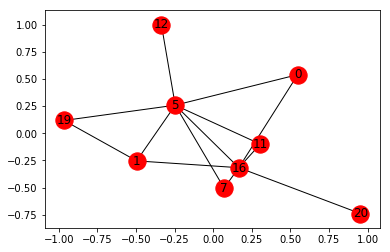

In [38]:
G = nx.Graph()
G.add_weighted_edges_from(edges)

pos = nx.spring_layout(G)

nx.draw_networkx(G, pos)

In [35]:
for i in range(len(sources)):
    print i, ":", sources[i]

0 : telegraph.co.uk
1 : foxnews.com
2 : ap.org
3 : businessinsider.in
4 : independent.co.uk
5 : reuters.com
6 : wikinews.org
7 : cnn.com
8 : techcrunch.com
9 : aa.com.tr
10 : allafrica.com
11 : nytimes.com
12 : bloomberg.com
13 : bbc.co.uk
14 : latimes.com
15 : rt.com
16 : france24.com
17 : chinadaily.com.cn
18 : theguardian.com
19 : washingtonpost.com
20 : middleeasteye.net
21 : aljazeera.com


## Model source similarity